In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from tensorflow.keras.layers import Conv2D,Flatten,Dense,MaxPool2D,BatchNormalization,GlobalAveragePooling2D
from tensorflow.keras.applications.resnet50 import preprocess_input,decode_predictions
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Sequential,Model
import matplotlib.pyplot as plt
import numpy as np


In [ ]:
img_height, img_width = (224,224)
batch_size = 32

train_data_dir = "/content/drive/MyDrive/CS737 Assignment/COVID_19_CT_Data/Train"
test_data_dir = "/content/drive/MyDrive/CS737 Assignment/COVID_19_CT_Data/Test"

In [ ]:
train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   validation_split=0.4)
train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size = (img_height,img_width),
    batch_size = batch_size,
    class_mode = 'categorical',
    subset = 'training'
)

Found 845 images belonging to 2 classes.


In [ ]:
test_generator = train_datagen.flow_from_directory(
    test_data_dir,
    target_size = (img_height,img_width),
    batch_size = 1,
    class_mode = 'categorical',
    subset='validation'
)

Found 233 images belonging to 2 classes.


In [ ]:
base_model = ResNet50(include_top=False,weights='imagenet')
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024,activation='relu')(x)
predictions = Dense(train_generator.num_classes,activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=predictions)
for layer in base_model.layers:
  layer.trainable = False;
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])
model.fit(train_generator,epochs=10)

In [ ]:
model.save('/content/drive/MyDrive/CS737 Assignment/covid.h5')

In [ ]:
test_loss, test_acc = model.evaluate(test_generator,verbose=2)
print("\n Test Accuracy:",test_acc)

233/233 - 68s - loss: 1.0487 - accuracy: 0.5408

 Test Accuracy: 0.540772557258606


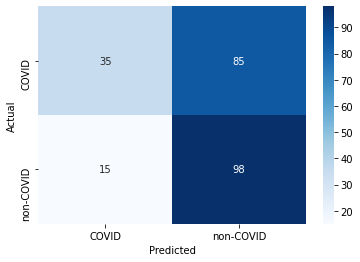

test accuracy: 57.08154506437768


In [ ]:
import pandas as pd
import seaborn as sn
import tensorflow as tf

model = tf.keras.models.load_model("/content/drive/MyDrive/CS737 Assignment/covid.h5")
filenames = test_generator.filenames
nb_samples = len(test_generator)
y_prob=[]
y_act=[]
test_generator.reset()
for _ in range(nb_samples):
  X_test, Y_test = test_generator.next()
  y_prob.append(model.predict(X_test))
  y_act.append(Y_test)

predicted_class = [list(train_generator.class_indices.keys())[i.argmax()]for i in y_prob]
actual_class = [list(train_generator.class_indices.keys())[i.argmax()]for i in y_act]

out_df = pd.DataFrame(np.vstack([predicted_class,actual_class]).T,columns=['predicted_class','actual_class'])
confusion_matrix = pd.crosstab(out_df['actual_class'],out_df['predicted_class'],rownames=['Actual'],colnames=['Predicted'])

sn.heatmap(confusion_matrix,cmap='Blues',annot=True,fmt='d')
plt.show()
print('test accuracy: {}'.format((np.diagonal(confusion_matrix).sum()/confusion_matrix.sum().sum()*100)))